In [1]:
library(tidyverse)
library(ggplot2)
library(ComplexHeatmap)
library(Seurat)
library(ggpubr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformati

In [2]:
esc.AS <- readRDS("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/RNA_analysis/RDS/esc_AS_remove_neg_904.rds")

# c3 XCI related

In [3]:
esc.AS[[]] %>% filter(plot_cluster == 3) %>% dim()

[1] 135  17

In [4]:
esc.AS[[]] %>% filter(plot_cluster == 0) %>% dim()

[1] 141  17

In [5]:
c0_heatmap <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/res/c0_B6_Cast_allele_diff.csv") %>% filter(FDR < 0.05)

New names:
• `` -> `...1`
Rows: 1690500 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): chrom1, chrom2
dbl (10): ...1, start1, end1, start2, end2, stats, FDR, index1, index2, p_diff

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
selout <- c0_heatmap %>% filter(stats > 0.5*141*141) %>% mutate(temp = paste0(index1, '-',index2)) %>% pull(temp)

In [7]:
new_index <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/BA_related/DI/dynamic_data/index_c3_down.csv")
c3_heatmap <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/res/c3_Cast_XCI_diff.csv") %>% filter(stats > 0.5*135*135) %>% filter(FDR < 0.05)
c3_heatmap <- c3_heatmap %>% mutate(temp = c(paste0(index1, '-',index2))) %>% filter(!temp %in% selout)
sel_di <- c3_heatmap %>% pull(temp)
new_index <- new_index %>% mutate(temp = paste0(index1, '-',index2)) %>% filter(temp %in% sel_di)

New names:
• `` -> `...1`
Rows: 112923 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): ...1, index1, index2, index_1D

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 1690500 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): chrom1, chrom2
dbl (10): ...1, start1, end1, start2, end2, stats, FDR, index1, index2, p_diff

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
di_data_Cast <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/BA_related/DI/dynamic_data/DI_dynamic_c3_down.csv")
di_data_Cast <- di_data_Cast %>% rename(index_1D = `...1`) %>% filter(index_1D %in% new_index$index_1D)
di_mean_per_cell <- di_data_Cast %>% column_to_rownames("index_1D") %>% colMeans() %>% as.data.frame()
names(di_mean_per_cell) <- "mean_value"
di_mean_per_cell <- di_mean_per_cell %>% rownames_to_column("cellname") %>% left_join(esc.AS@meta.data %>% select(cellname, plot_cluster)) %>% mutate(plot_cluster= paste0("c",plot_cluster))
di_mean_per_cell <- di_mean_per_cell %>% mutate(plot_cluster = factor(plot_cluster, levels = c("c0","c1","c2","c3","c4","c5")))

New names:
• `` -> `...1`
Rows: 112923 Columns: 905
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (905): ...1, d0A1, d0A10, d0A11, d0A12, d0A13, d0A14, d0A15, d0A16, d0A1...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(cellname)`


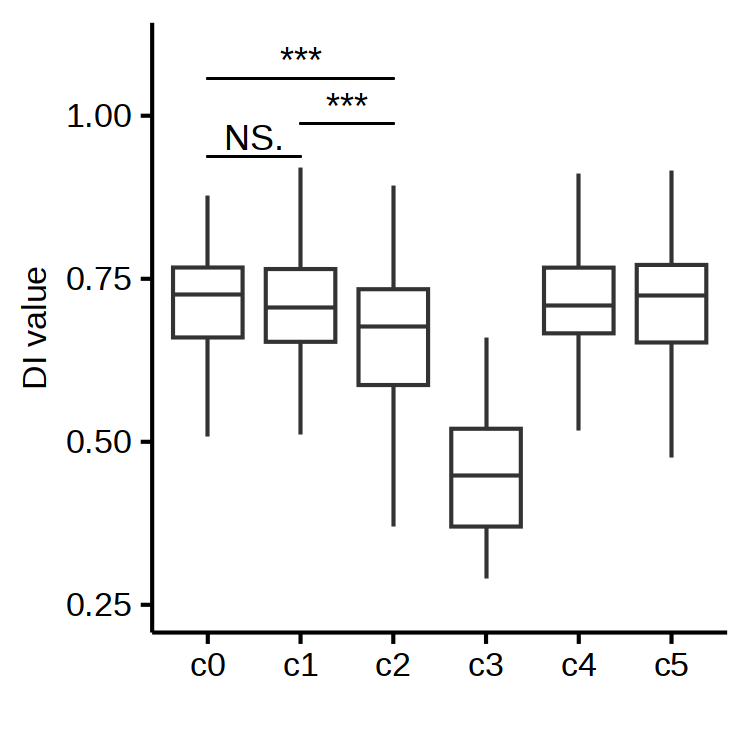

In [9]:
options(repr.plot.width = 2.5,repr.plot.height = 2.5, repr.plot.res = 300)
di_mean_per_cell %>% ggplot(aes(x=plot_cluster, y=mean_value)) + geom_boxplot(fatten = 1, outlier.shape = NA, linewidth = 0.35) + ylab("DI value") + xlab("") +
geom_signif(comparisons = list(c("c0","c1"),c("c0","c2"),c("c1","c2")),textsize = 3, y_position = c(0.9,1.02,0.95), map_signif_level = TRUE, tip_length=0, size = 0.25) +
scale_y_continuous(limits = c(0.25, 1.1), breaks = seq(0.25, 1.1, by = 0.25)) +
    theme_classic() +
                        theme(legend.position = "top",
  text = element_text(family="Arial", size=8),
  panel.border = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  axis.line = element_line(color="black", linewidth = 0.35),
  axis.ticks = element_line(color="black", linewidth = 0.35),
  axis.text = element_text(color="black",size=8),
  legend.key = element_rect(colour = NA),
  legend.key.width = unit(0.4, "cm"),
  legend.key.height = unit(0.4, "cm"),
  axis.title=element_text(color="black",size=8,face="plain"),
  ) 

In [10]:
di_value_c3_Cast <- di_mean_per_cell %>% mutate(type = "C3_related_XCI") %>% mutate(allele = "Cast")

In [11]:
di_data_B6 <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/BA_related/DI/dynamic_data/DI_dynamic_c3_down_B6.csv")
di_data_B6 <- di_data_B6 %>% rename(index_1D = `...1`) %>% filter(index_1D %in% new_index$index_1D)
di_mean_per_cell <- di_data_B6 %>% column_to_rownames("index_1D") %>% colMeans() %>% as.data.frame()
names(di_mean_per_cell) <- "mean_value"
di_mean_per_cell <- di_mean_per_cell %>% rownames_to_column("cellname") %>% left_join(esc.AS@meta.data %>% select(cellname, plot_cluster)) %>% mutate(plot_cluster= paste0("c",plot_cluster))
di_mean_per_cell <- di_mean_per_cell %>% mutate(plot_cluster = factor(plot_cluster, levels = c("c0","c1","c2","c3","c4","c5")))

New names:
• `` -> `...1`
Rows: 112923 Columns: 905
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (905): ...1, d0A1, d0A10, d0A11, d0A12, d0A13, d0A14, d0A15, d0A16, d0A1...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(cellname)`


Warning message:
“Removed 3 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 3 rows containing non-finite values (`stat_signif()`).”


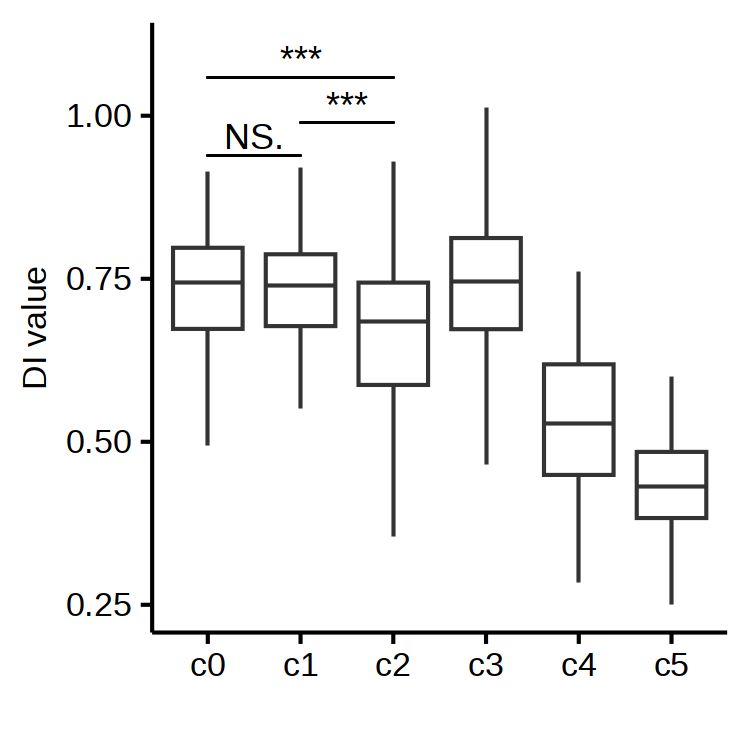

In [12]:
options(repr.plot.width = 2.5,repr.plot.height = 2.5, repr.plot.res = 300)
di_mean_per_cell %>% ggplot(aes(x=plot_cluster, y=mean_value)) + geom_boxplot(fatten = 1, outlier.shape = NA, linewidth = 0.35) + ylab("DI value") + xlab("") +
geom_signif(comparisons = list(c("c0","c1"),c("c0","c2"),c("c1","c2")),textsize = 3, y_position = c(0.9,1.02,0.95), map_signif_level = TRUE, tip_length=0, size = 0.25) +
scale_y_continuous(limits = c(0.25, 1.1), breaks = seq(0.25, 1.1, by = 0.25)) +
    theme_classic() +
                        theme(legend.position = "top",
  text = element_text(family="Arial", size=8),
  panel.border = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  axis.line = element_line(color="black", linewidth = 0.35),
  axis.ticks = element_line(color="black", linewidth = 0.35),
  axis.text = element_text(color="black",size=8),
  legend.key = element_rect(colour = NA),
  legend.key.width = unit(0.4, "cm"),
  legend.key.height = unit(0.4, "cm"),
  axis.title=element_text(color="black",size=8,face="plain"),
  ) 

In [13]:
di_value_c3_B6 <- di_mean_per_cell %>% mutate(type = "C3_related_XCI") %>% mutate(allele = "B6")

`summarise()` has grouped output by 'plot_cluster'. You can override using the
`.groups` argument.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


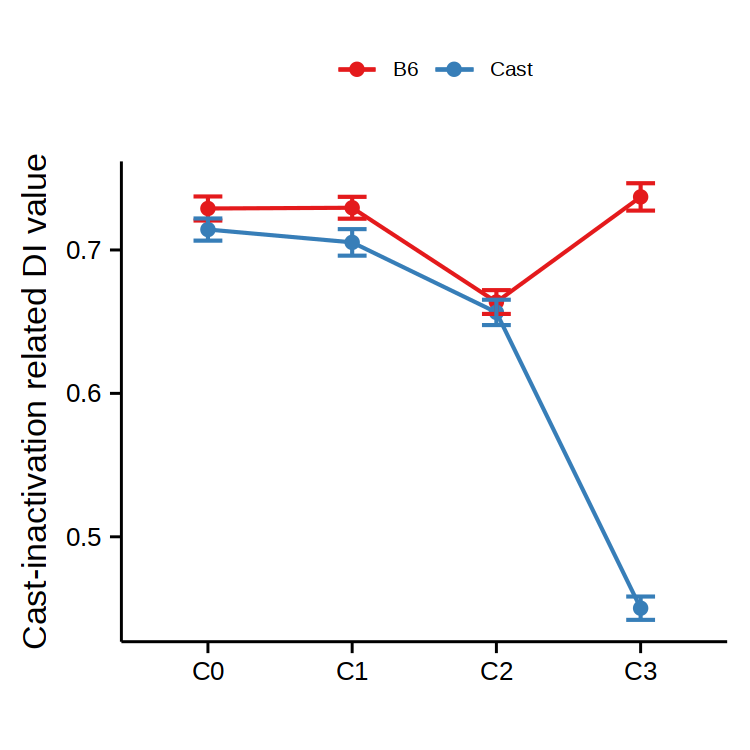

In [14]:
rbind(di_value_c3_B6, di_value_c3_Cast) %>% group_by(plot_cluster, allele) %>%
    summarise(mean = mean(mean_value), sd = sd(mean_value), n = n(), se = sd/sqrt(n)) %>%
    mutate(num = str_extract(plot_cluster, "[0-9]+"), plot_cluster = paste0("C",num)) %>%
    filter(!plot_cluster %in% c("C4","C5")) %>%
    ggplot(aes(x=plot_cluster, y=mean, group=allele, color=allele)) + 
    geom_line(size = 0.35) +
    geom_point(size = 0.85)+
    geom_errorbar(aes(ymin=mean-se, ymax=mean+se), width=.4,linewidth = 0.35,
                position=position_dodge(0))   + ylab('Cast-inactivation related DI value') + xlab("Cluster")+ scale_colour_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'),name = "") +
    theme_classic() +
          theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.4, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  ) + xlab("") 

Joining with `by = join_by(cellname, plot_cluster, type)`


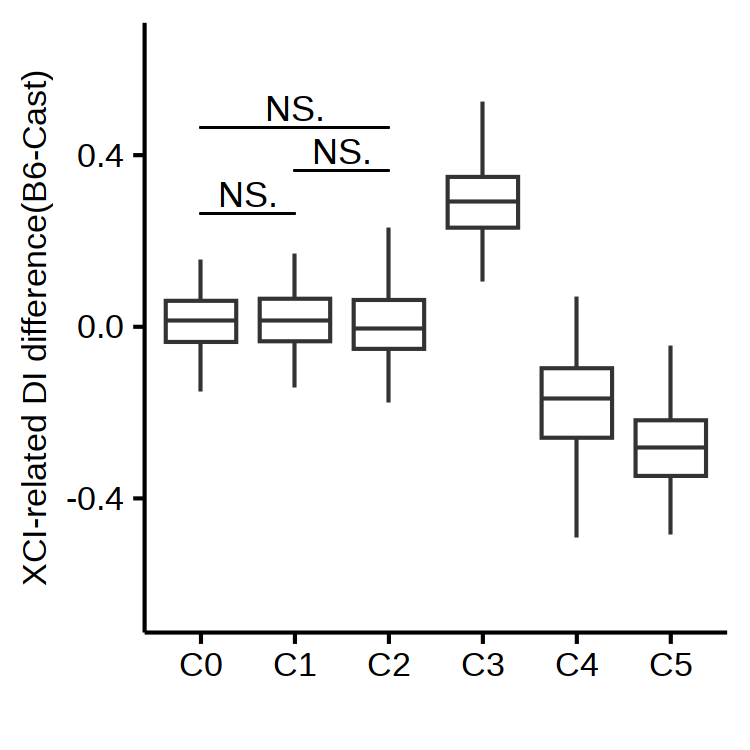

In [15]:
di_value_c3_B6 %>% rename(B6_value = mean_value) %>% select(-allele) %>% left_join(di_value_c3_Cast %>% rename(Cast_value = mean_value) %>% select(-allele)) %>%
    mutate(num = str_extract(plot_cluster, "[0-9]+"), plot_cluster = paste0("C",num)) %>%
    mutate(diff = B6_value - Cast_value) %>%
    ggplot(aes(x=plot_cluster, y=diff)) +
    geom_boxplot(fatten = 1, outlier.shape = NA, linewidth = 0.35) + ylab("XCI-related DI difference(B6-Cast)") + xlab("") +
    geom_signif(comparisons = list(c("C0","C1"),c("C0","C2"),c("C1","C2")),textsize = 3, y_position = c(0.2,0.4,0.3), map_signif_level = TRUE, tip_length=0, size = 0.25) +
        theme_classic() +
                            theme(legend.position = "top",
    text = element_text(family="Arial", size=8),
    panel.border = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    axis.line = element_line(color="black", linewidth = 0.35),
    axis.ticks = element_line(color="black", linewidth = 0.35),
    axis.text = element_text(color="black",size=8),
    legend.key = element_rect(colour = NA),
    legend.key.width = unit(0.4, "cm"),
    legend.key.height = unit(0.4, "cm"),
    axis.title=element_text(color="black",size=8,face="plain"),
    ) 

# c5 XCI related

In [16]:
esc.AS[[]] %>% filter(plot_cluster == 0) %>% dim()

[1] 141  17

In [17]:
c0_heatmap <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/res/c0_B6_Cast_allele_diff.csv") %>% filter(FDR < 0.05) %>% filter(stats < 0.5*141*141) %>% mutate(temp = paste0(index1, "-", index2))
c5_heatmap <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/res/c5_B6_XCI_diff.csv") %>% filter(FDR < 0.05) %>% filter(stats < 0.5*153*153) %>% mutate(temp = paste0(index1, "-", index2))

New names:
• `` -> `...1`
Rows: 1690500 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): chrom1, chrom2
dbl (10): ...1, start1, end1, start2, end2, stats, FDR, index1, index2, p_diff

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 1690500 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): chrom1, chrom2
dbl (10): ...1, start1, end1, start2, end2, stats, FDR, index1, index2, p_diff

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [18]:
c5_heatmap <- c5_heatmap %>% filter(!temp %in% c0_heatmap$temp)

In [19]:
index <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/dynamic_data/index_c5_down.csv") %>% mutate(temp = paste0(index1, "-", index2))
index <- index %>% filter(temp %in% c5_heatmap$temp) %>% select(-"...1")

New names:
• `` -> `...1`
Rows: 188991 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): ...1, index1, index2, index_1D

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [20]:
di_data <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/dynamic_data/DI_dynamic_c5_down.csv") %>% rename(index_1D = `...1`)
di_data <- di_data %>% filter(index_1D %in% index$index_1D)
di_mean_per_cell <- di_data %>% column_to_rownames("index_1D") %>% colMeans() %>% as.data.frame()
names(di_mean_per_cell) <- "mean_value"
di_mean_per_cell <- di_mean_per_cell %>% rownames_to_column("cellname") %>% left_join(esc.AS@meta.data %>% select(cellname, plot_cluster)) %>% mutate(plot_cluster= paste0("c",plot_cluster))
di_mean_per_cell <- di_mean_per_cell %>% mutate(plot_cluster = factor(plot_cluster, levels = c("c0","c1","c2","c4","c5","c3")))
di_value_c5_B6 <- di_mean_per_cell %>% mutate(type = "C5_related_XCI") %>% mutate(allele = "B6")

New names:
• `` -> `...1`
Rows: 188991 Columns: 905
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (905): ...1, d0A1, d0A10, d0A11, d0A12, d0A13, d0A14, d0A15, d0A16, d0A1...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(cellname)`


In [21]:
di_data <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/BA_related/DI/dynamic_data/DI_dynamic_c5_down_Cast.csv") %>% rename(index_1D = `...1`)
di_data <- di_data %>% filter(index_1D %in% index$index_1D)
di_mean_per_cell <- di_data %>% column_to_rownames("index_1D") %>% colMeans() %>% as.data.frame()
names(di_mean_per_cell) <- "mean_value"
di_mean_per_cell <- di_mean_per_cell %>% rownames_to_column("cellname") %>% left_join(esc.AS@meta.data %>% select(cellname, plot_cluster)) %>% mutate(plot_cluster= paste0("c",plot_cluster))
di_mean_per_cell <- di_mean_per_cell %>% mutate(plot_cluster = factor(plot_cluster, levels = c("c0","c1","c2","c4","c5","c3")))
di_value_c5_Cast <- di_mean_per_cell %>% mutate(type = "C5_related_XCI") %>% mutate(allele = "Cast")

New names:
• `` -> `...1`
Rows: 188991 Columns: 905
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (905): ...1, d0A1, d0A10, d0A11, d0A12, d0A13, d0A14, d0A15, d0A16, d0A1...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(cellname)`


`summarise()` has grouped output by 'plot_cluster'. You can override using the
`.groups` argument.


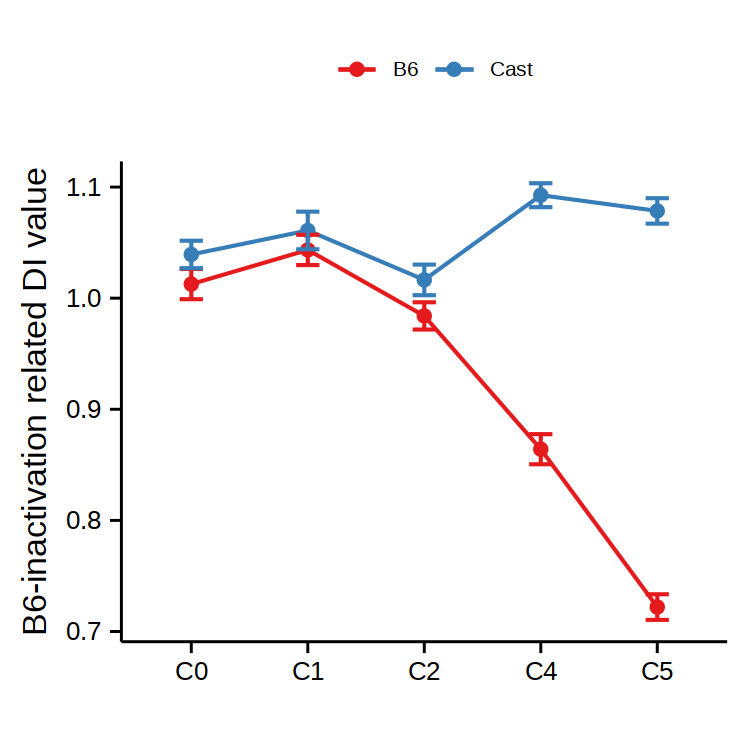

In [22]:
rbind(di_value_c5_B6, di_value_c5_Cast) %>% group_by(plot_cluster, allele) %>%
    summarise(mean = mean(mean_value), sd = sd(mean_value), n = n(), se = sd/sqrt(n)) %>%
    mutate(num = str_extract(plot_cluster, "[0-9]+"), plot_cluster = paste0("C",num)) %>%
    filter(!plot_cluster %in% c("C3")) %>%
    ggplot(aes(x=plot_cluster, y=mean, group=allele, color=allele)) + 
    geom_line(size = 0.35) +
    geom_point(size = 0.85)+
    geom_errorbar(aes(ymin=mean-se, ymax=mean+se), width=.4,linewidth = 0.35,
                position=position_dodge(0))   + ylab('B6-inactivation related DI value') + xlab("Cluster")+ scale_colour_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'),name = "") +
    theme_classic() +
          theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.4, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  ) + xlab("") 

Joining with `by = join_by(cellname, plot_cluster, type)`


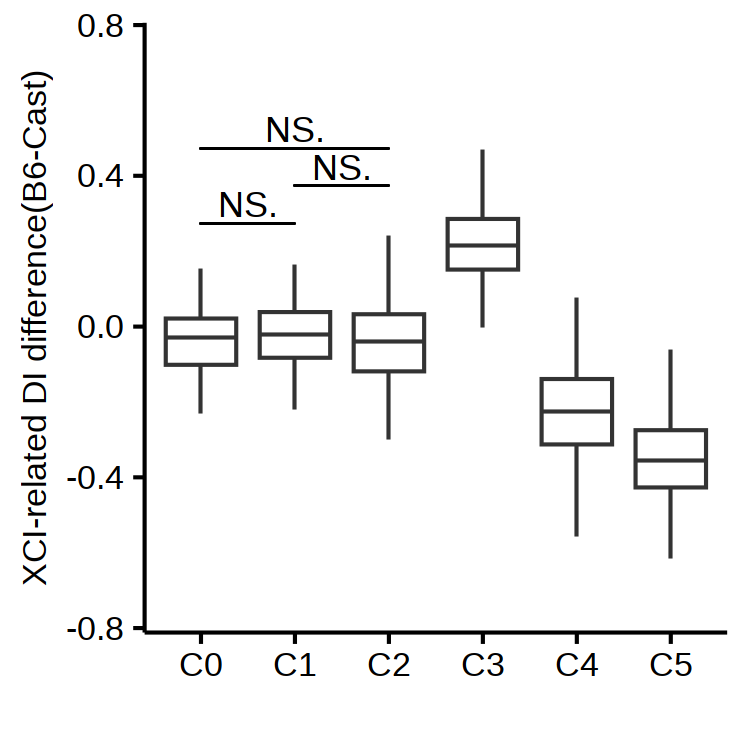

In [23]:
di_value_c5_B6 %>% rename(B6_value = mean_value) %>% select(-allele) %>% left_join(di_value_c5_Cast %>% rename(Cast_value = mean_value) %>% select(-allele)) %>%
    mutate(num = str_extract(plot_cluster, "[0-9]+"), plot_cluster = paste0("C",num)) %>%
    mutate(diff = B6_value - Cast_value) %>%
    ggplot(aes(x=plot_cluster, y=diff)) +
    geom_boxplot(fatten = 1, outlier.shape = NA, linewidth = 0.35) + ylab("XCI-related DI difference(B6-Cast)") + xlab("") +
    geom_signif(comparisons = list(c("C0","C1"),c("C0","C2"),c("C1","C2")),textsize = 3, y_position = c(0.2,0.4,0.3), map_signif_level = TRUE, tip_length=0, size = 0.25) +
        theme_classic() +
                            theme(legend.position = "top",
    text = element_text(family="Arial", size=8),
    panel.border = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    axis.line = element_line(color="black", linewidth = 0.35),
    axis.ticks = element_line(color="black", linewidth = 0.35),
    axis.text = element_text(color="black",size=8),
    legend.key = element_rect(colour = NA),
    legend.key.width = unit(0.4, "cm"),
    legend.key.height = unit(0.4, "cm"),
    axis.title=element_text(color="black",size=8,face="plain"),
    ) 

# common

In [24]:
sel_both_di <- intersect(c3_heatmap$temp,c5_heatmap$temp)

In [25]:
c5_heatmap %>% filter(temp %in% sel_both_di) %>% dim()

[1] 81871    13

In [26]:
sel_both_di %>% length()

[1] 81871

In [27]:
index <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/dynamic_data/index_c5_down.csv") %>% mutate(temp = paste0(index1, "-", index2))
di_data <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/dynamic_data/DI_dynamic_c5_down.csv") %>% rename(index_1D = `...1`)
c5_heatmap <- c5_heatmap %>% filter(temp %in% sel_both_di)
index <- index %>% filter(temp %in% c5_heatmap$temp) %>% select(-"...1")
di_data <- di_data %>% filter(index_1D %in% index$index_1D)

New names:
• `` -> `...1`
Rows: 188991 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): ...1, index1, index2, index_1D

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 188991 Columns: 905
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (905): ...1, d0A1, d0A10, d0A11, d0A12, d0A13, d0A14, d0A15, d0A16, d0A1...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [28]:
index <- index %>% mutate(dist = abs(floor((index1+index2)/2)-5173)) %>% mutate(type = ifelse(dist < 100,"<2Mb",ifelse(dist < 2500, "2-50Mb", ">50Mb"))) %>% 
    mutate(type = factor(type, levels = c("<2Mb","2-50Mb",">50Mb")))

In [29]:
esc.AS@meta.data -> metadata

In [31]:
dist_di_value_B6_c1 <- 
    di_data %>% column_to_rownames("index_1D") %>% t() %>% as.data.frame() %>% rownames_to_column("cellname") %>% 
    left_join(metadata %>% select(cellname, plot_cluster)) %>% select(-cellname) %>% filter(plot_cluster == 1) %>% select(-plot_cluster) %>% 
    summarise_all(mean)

Joining with `by = join_by(cellname)`


In [32]:
dist_di_value_B6_c2 <- 
    di_data %>% column_to_rownames("index_1D") %>% t() %>% as.data.frame() %>% rownames_to_column("cellname") %>% 
    left_join(metadata %>% select(cellname, plot_cluster)) %>% select(-cellname) %>% filter(plot_cluster == 2) %>% select(-plot_cluster) %>% 
    summarise_all(mean)

Joining with `by = join_by(cellname)`


In [33]:
dist_di_value_B6_c1 <- dist_di_value_B6_c1 %>% t() %>% as.data.frame()
names(dist_di_value_B6_c1) <- "B6_c1"

In [34]:
dist_di_value_B6_c2 <- dist_di_value_B6_c2 %>% t() %>% as.data.frame()
names(dist_di_value_B6_c2) <- "B6_c2"

In [35]:
dist_di_value_B6_c2 %>% rownames_to_column("index") %>% left_join(dist_di_value_B6_c1 %>% rownames_to_column("index")) %>%
    mutate(ratio = (B6_c1-B6_c2)/B6_c1) %>% summarise(mean = mean(ratio), sd = sd(ratio), n = n(), se = sd(ratio)/sqrt(n()))

Joining with `by = join_by(index)`


mean,sd,n,se
<dbl>,<dbl>,<int>,<dbl>
0.05835959,0.2253656,81871,0.0007876307


In [36]:
di_mean_per_cell <- di_data %>% column_to_rownames("index_1D") %>% colMeans() %>% as.data.frame()
names(di_mean_per_cell) <- "mean_value"
di_mean_per_cell <- di_mean_per_cell %>% rownames_to_column("cellname") %>% left_join(esc.AS@meta.data %>% select(cellname, plot_cluster)) %>% mutate(plot_cluster= paste0("c",plot_cluster))
di_mean_per_cell <- di_mean_per_cell %>% mutate(plot_cluster = factor(plot_cluster, levels = c("c0","c1","c2","c4","c5","c3")))

Joining with `by = join_by(cellname)`


In [37]:
di_mean_per_cell_c5 <- di_mean_per_cell

In [38]:
new_index <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/BA_related/DI/dynamic_data/index_c3_down.csv")
di_data <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/BA_related/DI/dynamic_data/DI_dynamic_c3_down.csv")
c3_heatmap <- c3_heatmap %>% filter(temp %in% sel_both_di)

New names:
• `` -> `...1`
Rows: 112923 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): ...1, index1, index2, index_1D

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 112923 Columns: 905
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (905): ...1, d0A1, d0A10, d0A11, d0A12, d0A13, d0A14, d0A15, d0A16, d0A1...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [39]:
new_index <- new_index %>% mutate(temp = paste0(index1, '-',index2)) %>% filter(temp %in% c3_heatmap$temp)

In [40]:
di_data <- di_data %>% rename(index_1D = `...1`) %>% filter(index_1D %in% new_index$index_1D)

In [41]:
dist_di_value_Cast_c1 <- 
    di_data %>% column_to_rownames("index_1D") %>% t() %>% as.data.frame() %>% rownames_to_column("cellname") %>% 
    left_join(metadata %>% select(cellname, plot_cluster)) %>% select(-cellname) %>% filter(plot_cluster == 1) %>% select(-plot_cluster) %>% 
    summarise_all(mean)

Joining with `by = join_by(cellname)`


In [42]:
dist_di_value_Cast_c2 <- 
    di_data %>% column_to_rownames("index_1D") %>% t() %>% as.data.frame() %>% rownames_to_column("cellname") %>% 
    left_join(metadata %>% select(cellname, plot_cluster)) %>% select(-cellname) %>% filter(plot_cluster == 2) %>% select(-plot_cluster) %>% 
    summarise_all(mean)

Joining with `by = join_by(cellname)`


In [43]:
dist_di_value_Cast_c1 <- dist_di_value_Cast_c1 %>% t() %>% as.data.frame()
names(dist_di_value_Cast_c1) <- "Cast_c1"

In [44]:
dist_di_value_Cast_c2 <- dist_di_value_Cast_c2 %>% t() %>% as.data.frame()
names(dist_di_value_Cast_c2) <- "Cast_c2"

In [45]:
plot <- dist_di_value_B6_c2 %>% rownames_to_column("index") %>% left_join(dist_di_value_B6_c1 %>% rownames_to_column("index")) %>%
    mutate(ratio = (B6_c1-B6_c2)/B6_c1) %>% left_join(index %>% select(index_1D, type, index1, index2) %>% rename(index = index_1D) %>% mutate(index = as.character(index))) %>% 
    filter(!(index1 >= 5173 & index1 <= 5185) & !(index2 >= 5173 & index2 <= 5185)) %>%
    group_by(type) %>%
    summarise(mean = mean(ratio), sd = sd(ratio), n = n(), se = sd(ratio)/sqrt(n())) %>% mutate(allele = "B6") %>%
    rbind(dist_di_value_Cast_c2 %>% rownames_to_column("index") %>% left_join(dist_di_value_Cast_c1 %>% rownames_to_column("index")) %>%
    mutate(ratio = (Cast_c1-Cast_c2)/Cast_c1) %>% left_join(index %>% select(index_1D, type, index1, index2) %>% rename(index = index_1D) %>% mutate(index = as.character(index))) %>% 
    filter(!(index1 >= 5173 & index1 <= 5185) & !(index2 >= 5173 & index2 <= 5185)) %>%
    group_by(type) %>%
    summarise(mean = mean(ratio), sd = sd(ratio), n = n(), se = sd(ratio)/sqrt(n())) %>% mutate(allele = "Cast"))

Joining with `by = join_by(index)`


Joining with `by = join_by(index)`
Joining with `by = join_by(index)`
Joining with `by = join_by(index)`


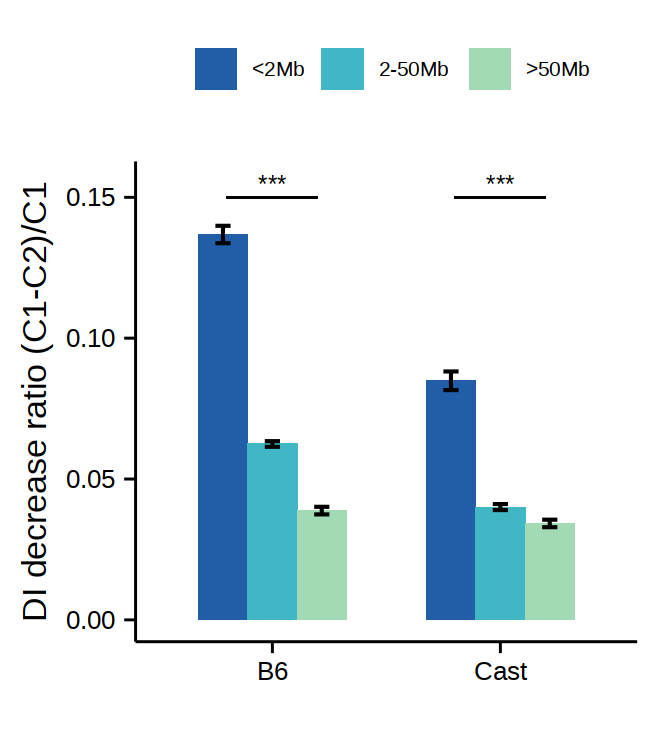

In [46]:
options(repr.plot.width=2.2,repr.plot.height=2.5,repr.plot.res=300)
plot %>% ggplot(aes(x = allele, y = mean, fill = type)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.65) +
  geom_errorbar(aes(ymin = mean - se, ymax = mean + se),
                position = position_dodge(0.65), width = 0.2, linewidth = 0.35) +

  theme_classic() + 
    scale_fill_manual(values = rev(c('#ffffcc','#a1dab4','#41b6c4','#225ea8')), name = "") +
ylab('DI decrease ratio (C1-C2)/C1') + xlab("") +
      theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.4, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  ) + geom_segment(aes(x = 0.8, xend = 1.2, y = 0.15, yend = 0.15), color = "black", linewidth = 0.25) + # 添加线条
  annotate("text", x = 1, y = 0.155, label = "***", size = 2)+
    geom_segment(aes(x = 1.8, xend = 2.2, y = 0.15, yend = 0.15), color = "black", linewidth = 0.25) + # 添加线条
  annotate("text", x = 2, y = 0.155, label = "***", size = 2)
# ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig3/fig3_dist_bar.svg", width = 2.2, height = 2.5, units = "in", dpi = 300)

In [47]:
dist_di_value_B6_c2 %>% rownames_to_column("index") %>% left_join(dist_di_value_B6_c1 %>% rownames_to_column("index")) %>%
    mutate(ratio = (B6_c1-B6_c2)/B6_c1) %>% left_join(index %>% select(index_1D, type, index1, index2) %>% rename(index = index_1D) %>% mutate(index = as.character(index))) %>% 
    filter(!(index1 >= 5173 & index1 <= 5185) & !(index2 >= 5173 & index2 <= 5185)) %>% aov(ratio ~ type, data = .) %>% summary

Joining with `by = join_by(index)`


Joining with `by = join_by(index)`


               Df Sum Sq Mean Sq F value Pr(>F)    
type            2     29   14.53   288.3 <2e-16 ***
Residuals   81443   4105    0.05                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [48]:
dist_di_value_Cast_c2 %>% rownames_to_column("index") %>% left_join(dist_di_value_Cast_c1 %>% rownames_to_column("index")) %>%
    mutate(ratio = (Cast_c1-Cast_c2)/Cast_c1) %>% left_join(index %>% select(index_1D, type, index1, index2) %>% rename(index = index_1D) %>% mutate(index = as.character(index))) %>% 
    filter(!(index1 >= 5173 & index1 <= 5185) & !(index2 >= 5173 & index2 <= 5185)) %>% aov(ratio ~ type, data = .) %>% summary

Joining with `by = join_by(index)`


Joining with `by = join_by(index)`


               Df Sum Sq Mean Sq F value Pr(>F)    
type            2      7   3.464   63.59 <2e-16 ***
Residuals   81443   4437   0.054                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [49]:
di_mean_per_cell <- di_data %>% column_to_rownames("index_1D") %>% colMeans() %>% as.data.frame()
names(di_mean_per_cell) <- "mean_value"
di_mean_per_cell <- di_mean_per_cell %>% rownames_to_column("cellname") %>% left_join(esc.AS@meta.data %>% select(cellname, plot_cluster)) %>% mutate(plot_cluster= paste0("c",plot_cluster))
di_mean_per_cell <- di_mean_per_cell %>% mutate(plot_cluster = factor(plot_cluster, levels = c("c0","c1","c2","c3","c4","c5")))

Joining with `by = join_by(cellname)`


`summarise()` has grouped output by 'plot_cluster'. You can override using the
`.groups` argument.


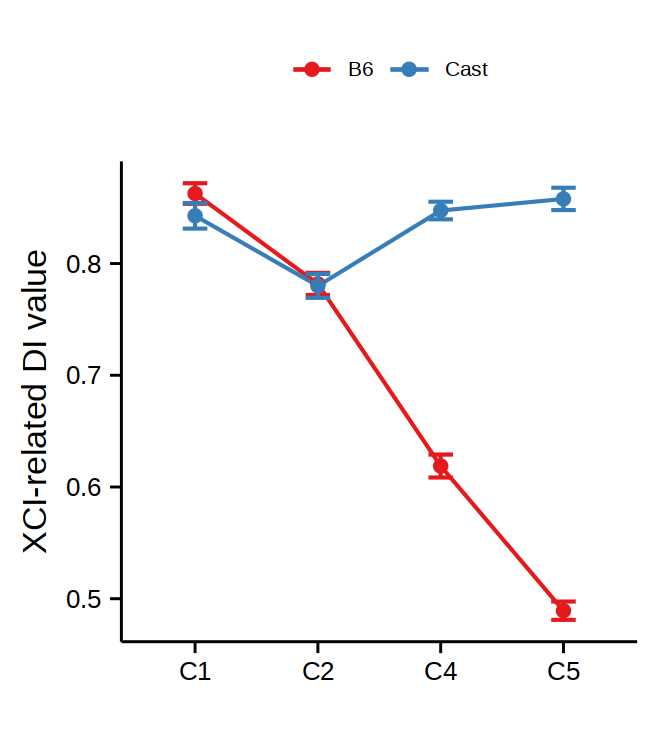

In [50]:
options(repr.plot.width = 2.2,repr.plot.height = 2.5, repr.plot.res = 300)

di_mean_per_cell %>% mutate(allele = 'Cast') %>% rbind(di_mean_per_cell_c5 %>% mutate(allele = 'B6')) %>% group_by(plot_cluster, allele) %>%
    summarise(mean = mean(mean_value), sd = sd(mean_value), n = n(), se = sd/sqrt(n)) %>%
    mutate(num = str_extract(plot_cluster, "[0-9]+"), plot_cluster = paste0("C",num)) %>%
    filter(!plot_cluster %in% c("C0","C3")) %>%
    ggplot(aes(x=plot_cluster, y=mean, group=allele, color=allele)) + 
    geom_line(size = 0.35) +
    geom_point(size = 0.85)+
    geom_errorbar(aes(ymin=mean-se, ymax=mean+se), width=.4,linewidth = 0.35,
                position=position_dodge(0))   + ylab('XCI-related DI value') + scale_colour_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'),name = "") +
    theme_classic() +
          theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.4, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  ) + xlab("") 
# ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig3/fig3_DI_B6.svg", width = 2.2, height = 2.5, units = "in", dpi = 300)

`summarise()` has grouped output by 'plot_cluster'. You can override using the
`.groups` argument.


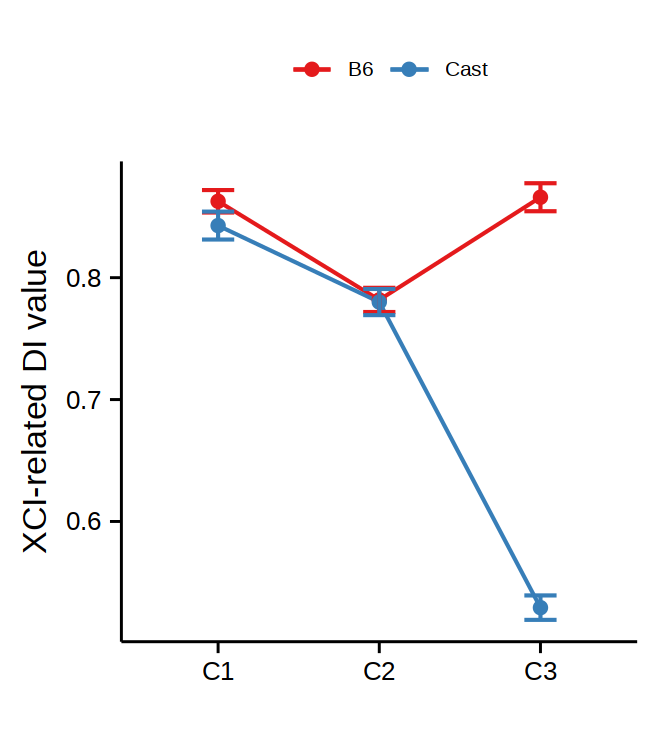

In [52]:
di_mean_per_cell %>% mutate(allele = 'Cast') %>% rbind(di_mean_per_cell_c5 %>% mutate(allele = 'B6')) %>% group_by(plot_cluster, allele) %>%
    summarise(mean = mean(mean_value), sd = sd(mean_value), n = n(), se = sd/sqrt(n)) %>%
    mutate(num = str_extract(plot_cluster, "[0-9]+"), plot_cluster = paste0("C",num)) %>%
    filter(!plot_cluster %in% c("C0","C4","C5")) %>%
    ggplot(aes(x=plot_cluster, y=mean, group=allele, color=allele)) + 
    geom_line(size = 0.35) +
    geom_point(size = 0.85)+
    geom_errorbar(aes(ymin=mean-se, ymax=mean+se), width=.4,linewidth = 0.35,
                position=position_dodge(0))   + ylab('XCI-related DI value') + scale_colour_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'),name = "") +
    theme_classic() +
          theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.4, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  ) + xlab("") 
# ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig3/fig3_DI_Cast.svg", width = 2.2, height = 2.5, units = "in", dpi = 300)

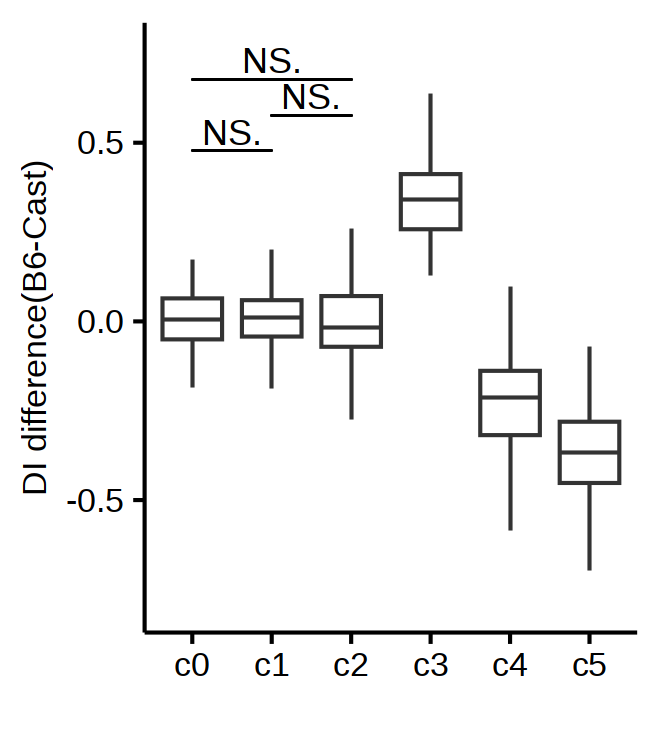

In [53]:
di_mean_per_cell %>% mutate(allele = 'Cast') %>% rbind(di_mean_per_cell_c5 %>% mutate(allele = 'B6')) %>%
    pivot_wider(names_from = allele, values_from = mean_value) %>% mutate(diff = B6-Cast) %>%
    ggplot(aes(x=plot_cluster, y=diff)) + geom_boxplot(outlier.shape = NA,fatten = 1, linewidth = 0.35) + 
    # geom_jitter(size = 0.25, width = 0.2, alpha = 0.5, shape = 21) +
    geom_signif(test='t.test',comparisons = list(c("c0","c1"),c("c0","c2"),c("c1","c2")),textsize = 3, y_position = c(0.4,0.6,0.5), map_signif_level = TRUE, tip_length=0, size = 0.25) +
        theme_classic() +
                        theme(legend.position = "top",
  text = element_text(family="Arial", size=8),
  panel.border = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  axis.line = element_line(color="black", linewidth = 0.35),
  axis.ticks = element_line(color="black", linewidth = 0.35),
  axis.text = element_text(color="black",size=8),
  legend.key = element_rect(colour = NA),
  legend.key.width = unit(0.4, "cm"),
  legend.key.height = unit(0.4, "cm"),
  axis.title=element_text(color="black",size=8,face="plain"),
  ) +xlab("") + ylab("DI difference(B6-Cast)")

# ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig3/fig3_DI_difference.svg", width = 2.2, height = 2.2, units = "in", dpi = 300)